# Zadanie 2

## Rekurenycjne odwracanie macierzy

In [1]:
import numpy as np

def multi_dot(dot_m, arrays): 
    '''
    function used to make multiple dots in one go
    '''
    result, op = dot_m(arrays[0], arrays[1])
    for i in range(2, len(arrays)):
        result, op_new = dot_m(result, arrays[i])
        op+=op_new
    return result, op


def recursive_inversion(matrix, dot_method):   
    '''
    function returns inverted matrix and operations it took to invert
    '''
    cnt = 0
    if matrix.shape[0] != matrix.shape[1]: raise Exception('Matrix is not a square')
    
    if matrix.shape == (1, 1):
        if matrix[0, 0] == 0: raise Exception('Matrix is invertible')
        cnt += 1
        return np.array([[1/matrix[0, 0]]]), cnt
    
    if matrix.shape == (2, 2):
        det = matrix[0, 0]*matrix[1, 1] - matrix[0, 1]*matrix[1, 0]
        if det == 0: raise Exception('Matrix is invertible')
        cnt += 6
        return np.array([[matrix[1, 1]/det, -matrix[0, 1]/det], [-matrix[1, 0]/det, matrix[0, 0]/det]]), cnt
    
    else:
        n = matrix.shape[0]
        m = n//2
        A = matrix[:m, :m]
        B = matrix[:m, m:]
        C = matrix[m:, :m]
        D = matrix[m:, m:]
        
        A_inv, cnt1 = recursive_inversion(A, dot_method)
        md_val_1, md_cnt_1 = multi_dot(dot_method, [C, A_inv, B])
        Common, cnt2 = recursive_inversion(D - md_val_1, dot_method)

        md_val_2, md_cnt_2 =multi_dot(dot_method, [A_inv, B, Common, C, A_inv])
        P = A_inv+md_val_2
        md_val_3, md_cnt_3 =multi_dot(dot_method, [A_inv, B, Common])
        Q = -md_val_3
        md_val_4, md_cnt_4 = multi_dot(dot_method, [Common, C, A_inv])
        R = -md_val_4

        S = Common  

        Top = np.row_stack([P, R])
        Bottom = np.row_stack([Q,S])
        cnt += cnt1 + cnt2 + md_cnt_1 + md_cnt_2 + md_cnt_3 + md_cnt_4

        return np.column_stack([Top, Bottom]), cnt
    



In [12]:
def assert_same(A, B, sigma = 1e-2):
    for i,row in enumerate(A):
        for j, el in enumerate(row):
            assert abs(el-B[i][j]) < sigma

In [3]:
import time
from matplotlib import pyplot as plt
from multi_algorithms import cauchy_binet_recursive, strassen_matrix_multiply


def test_algorithm(max_k):
    x = []
    y_t = [[] for _ in range(2)]
    y_op = [[] for _ in range(2)]
    for k in range(2,max_k+1):
        n = 2**k
        A = np.random.rand(n,n)

        start = time.time()
        A_inv, ops = recursive_inversion(A, cauchy_binet_recursive)
        end = time.time()

        assert_same(A_inv, np.linalg.inv(A))
        y_t[0].append(end-start)
        y_op[0].append(ops)

        start = time.time()
        A_inv, ops = recursive_inversion(A, strassen_matrix_multiply)
        end = time.time()

        assert_same(A_inv, np.linalg.inv(A))
        y_t[1].append(end-start)
        y_op[1].append(ops)

        x.append(k)


    return x, y_t, y_op


Tests

In [5]:
x, y_t, y_op = test_algorithm(8)


['0.0s', '0.0s', '0.02s', '0.25s', '1.79s', '9.86s', '68.38s']
['0.0s', '0.01s', '0.04s', '0.32s', '2.28s', '9.87s', '69.11s']


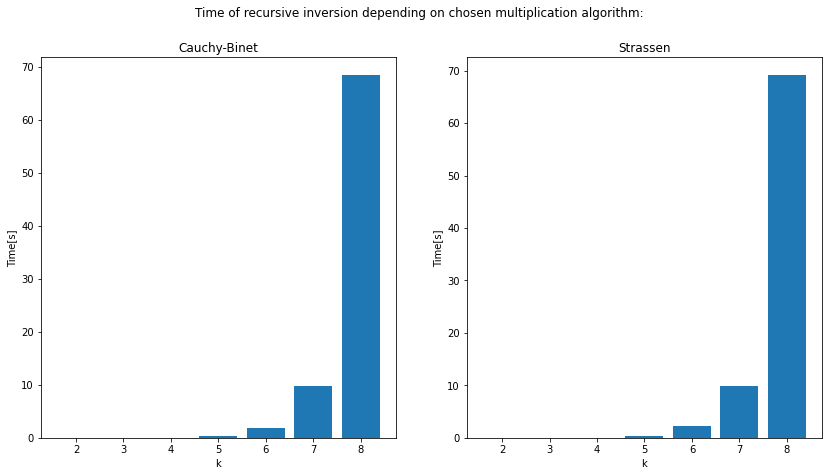

In [6]:
# plot two bars on one plot
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.suptitle('Time of recursive inversion depending on chosen multiplication algorithm:')
plt.bar(x, y_t[0])
plt.title('Cauchy-Binet')
plt.xlabel('k')
plt.ylabel('Time[s]')
plt.subplot(1,2,2)
plt.bar(x, y_t[1])
plt.title('Strassen')
plt.xlabel('k')
plt.ylabel('Time[s]')

print([str(round(el,2)) + 's' for el in y_t[0]])
print([str(round(el,2)) + 's' for el in y_t[1]])


[132, 1384, 12368, 104096, 853312, 6908544, 55596288]
[262, 2994, 26158, 205026, 1525102, 11039874, 78744718]


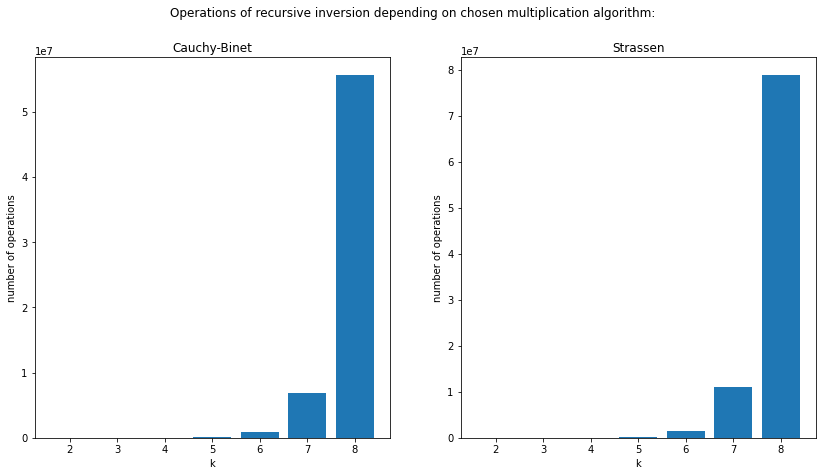

In [7]:
# plot two bars on one plot
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.suptitle('Operations of recursive inversion depending on chosen multiplication algorithm:')
plt.bar(x, y_op[0])
plt.title('Cauchy-Binet')
plt.xlabel('k')
plt.ylabel('number of operations')
plt.subplot(1,2,2)
plt.bar(x, y_op[1])
plt.title('Strassen')
plt.xlabel('k')
plt.ylabel('number of operations')

print(y_op[0])
print(y_op[1])

## LU faktoryzacja

In [8]:
def lu_decomposition(A, dot_method):
    n = len(A)
    
    if n == 1:
        L = np.array([[1]])
        U = A
        return L, U, 0

    A11 = A[:n//2, :n//2]
    A12 = A[:n//2, n//2:]
    A21 = A[n//2:, :n//2]
    A22 = A[n//2:, n//2:]

    L11, U11, count1 = lu_decomposition(A11, dot_method)
    U11_inv, count2 = recursive_inversion(U11, dot_method)
    L21, count3 = dot_method(A21, U11_inv)
    L11_inv, count4 = recursive_inversion(L11, dot_method)
    U12, count5 = dot_method(L11_inv, A12)
    A21U11_inv, count6 = dot_method(A21, U11_inv)
    L11_invA12, count7 = dot_method(L11_inv, A12)
    tmp, count8 = dot_method(A21U11_inv, L11_invA12)
    S, count9 = A22 - tmp, tmp.shape[0]*tmp.shape[0]
    Ls, Us, count10 = lu_decomposition(S, dot_method)
    U22 = Us
    L22 = Ls

    L1 = np.hstack((L11, np.zeros((n//2, n//2))))
    L2 = np.hstack((L21, L22))
    L = np.vstack((L1, L2))

    U1 = np.hstack((U11, U12))
    U2 = np.hstack((np.zeros((n//2, n//2)), U22))
    U = np.vstack((U1, U2))
    
    count = count1 + count2 + count3 + count4 + count5 + count6 + count7 + count8 + count9 + count10

    return L, U, count

In [9]:
def test_lu(max_k):
    x = []
    y_t = [[] for _ in range(2)]
    y_op = [[] for _ in range(2)]
    for k in range(2,max_k+1):
        n = 2**k
        A = np.random.rand(n,n)

        start = time.time()
        L, U, ops = lu_decomposition(A, cauchy_binet_recursive)
        end = time.time()
         
        assert_same(A, L @ U)
        y_t[0].append(end-start)
        y_op[0].append(ops)

        start = time.time()
        L, U, ops = lu_decomposition(A, strassen_matrix_multiply)
        end = time.time()

        assert_same(A, L @ U)
        y_t[1].append(end-start)
        y_op[1].append(ops)

        x.append(k)


    return x, y_t, y_op

Testy

In [13]:
x, y_t, y_op = test_lu(8)

['0.0s', '0.0s', '0.01s', '0.1s', '0.81s', '6.4s', '51.62s']
['0.0s', '0.0s', '0.02s', '0.15s', '1.1s', '7.82s', '54.38s']


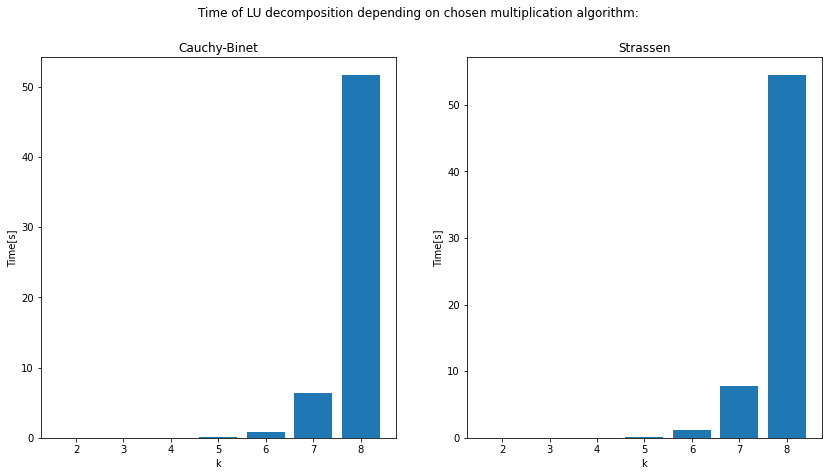

In [14]:
# plot two bars on one plot
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.suptitle('Time of LU decomposition depending on chosen multiplication algorithm:')
plt.bar(x, y_t[0])
plt.title('Cauchy-Binet')
plt.xlabel('k')
plt.ylabel('Time[s]')
plt.subplot(1,2,2)
plt.bar(x, y_t[1])
plt.title('Strassen')
plt.xlabel('k')
plt.ylabel('Time[s]')

print([str(round(el,2)) + 's' for el in y_t[0]])
print([str(round(el,2)) + 's' for el in y_t[1]])

[92, 1024, 9680, 84032, 699840, 5711360, 46145792]
[157, 2089, 20315, 169557, 1307715, 9664565, 69757747]


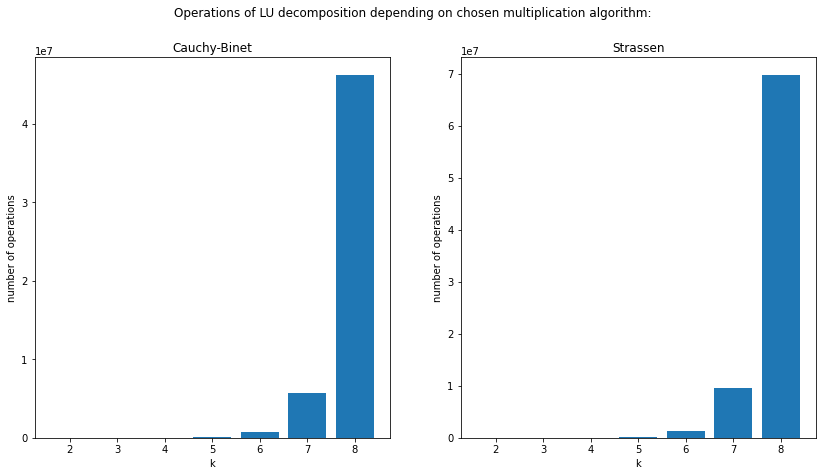

In [15]:
# plot two bars on one plot
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.suptitle('Operations of LU decomposition depending on chosen multiplication algorithm:')
plt.bar(x, y_op[0])
plt.title('Cauchy-Binet')
plt.xlabel('k')
plt.ylabel('number of operations')
plt.subplot(1,2,2)
plt.bar(x, y_op[1])
plt.title('Strassen')
plt.xlabel('k')
plt.ylabel('number of operations')

print(y_op[0])
print(y_op[1])

## Wyznacznik

In [16]:
def det(A, dot_method):
    
    L, U, count = lu_decomposition(A, dot_method)

    det_L = np.prod(np.diagonal(L))  
    det_U = np.prod(np.diagonal(U))  

    return det_U*det_L, count + 2*U.shape[0] + 1

In [26]:
def test_det(max_k, sigma=10e-4):
    x = []
    y_t = [[] for _ in range(2)]
    y_op = [[] for _ in range(2)]
    for k in range(2,max_k+1):
        print(f"Tests for k = {k}:")
        n = 2**k
        A = np.random.rand(n,n)

        start = time.time()
        detA, ops = det(A, cauchy_binet_recursive)
        end = time.time()

        res1 = detA - np.linalg.det(A)
        print("{:.2e}".format(res1), "ch", end= " \t")

        y_t[0].append(end-start)
        y_op[0].append(ops)

        start = time.time()
        detA, ops = det(A, strassen_matrix_multiply)
        end = time.time()

        res2 = detA - np.linalg.det(A)
        print("{:.2e}".format(res2), "st")

        y_t[1].append(end-start)
        y_op[1].append(ops)

        x.append(k)


    return x, y_t, y_op

Testy

In [27]:
x, y_t, y_op = test_det(8)

Tests for k = 2:
3.47e-18 ch 	1.39e-17 st
Tests for k = 3:
8.33e-17 ch 	-2.64e-16 st
Tests for k = 4:
-5.20e-18 ch 	4.66e-15 st
Tests for k = 5:
-2.23e-13 ch 	1.42e-10 st
Tests for k = 6:
-5.61e-03 ch 	-3.67e-02 st
Tests for k = 7:
-1.02e+29 ch 	2.04e+32 st
Tests for k = 8:
6.65e+106 ch 	-7.44e+109 st


['0.0s', '0.0s', '0.01s', '0.11s', '0.82s', '6.5s', '51.98s']
['0.0s', '0.0s', '0.02s', '0.16s', '1.1s', '7.79s', '54.57s']


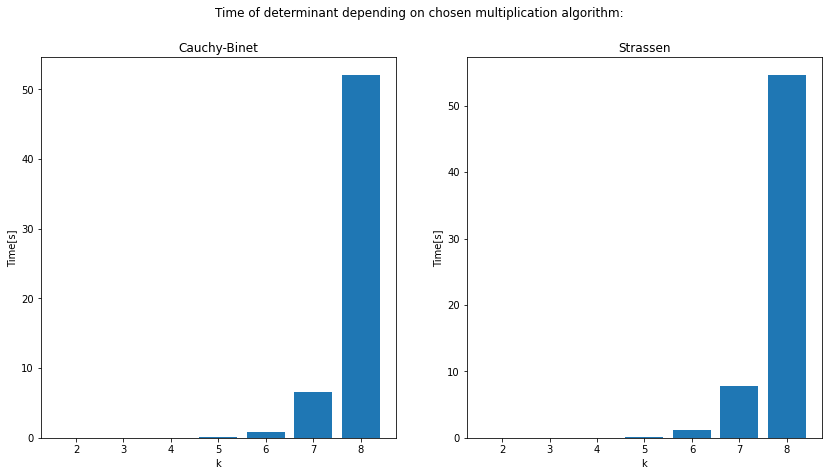

In [28]:
# plot two bars on one plot
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.suptitle('Time of determinant depending on chosen multiplication algorithm:')
plt.bar(x, y_t[0])
plt.title('Cauchy-Binet')
plt.xlabel('k')
plt.ylabel('Time[s]')
plt.subplot(1,2,2)
plt.bar(x, y_t[1])
plt.title('Strassen')
plt.xlabel('k')
plt.ylabel('Time[s]')

print([str(round(el,2)) + 's' for el in y_t[0]])
print([str(round(el,2)) + 's' for el in y_t[1]])

[101, 1041, 9713, 84097, 699969, 5711617, 46146305]
[166, 2106, 20348, 169622, 1307844, 9664822, 69758260]


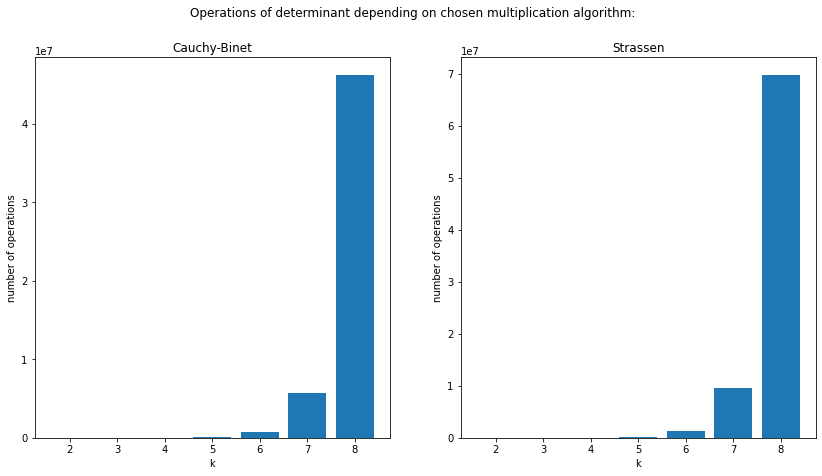

In [29]:
# plot two bars on one plot
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.suptitle('Operations of determinant depending on chosen multiplication algorithm:')
plt.bar(x, y_op[0])
plt.title('Cauchy-Binet')
plt.xlabel('k')
plt.ylabel('number of operations')
plt.subplot(1,2,2)
plt.bar(x, y_op[1])
plt.title('Strassen')
plt.xlabel('k')
plt.ylabel('number of operations')

print(y_op[0])
print(y_op[1])